In [1]:
%load_ext autoreload
%autoreload 2

In [111]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.stats import norm, multivariate_normal
import torch
import seaborn as sns
from typing import Sequence

In [201]:
np.full(4, 1/2)

array([0.5, 0.5, 0.5, 0.5])

In [233]:
class GMM:
    """
    Full covariance Gaussian Mixture Model,
    trained using Expectation Maximization.

    Parameters
    ----------
    n_components : int
        Number of clusters/mixture components in which the data will be
        partitioned into.

    n_iters : int
        Maximum number of iterations to run the algorithm.

    tol : float
        Tolerance. If the log-likelihood between two iterations is smaller than
        the specified tolerance level, the algorithm will stop performing the
        EM optimization.

    seed : int
        Seed / random state used to initialize the parameters.
    """

    def __init__(self, n_components: int, n_iters: int, tol: float, seed: int):
        self.n_components = n_components
        self.n_iters = n_iters
        self.tol = tol
        self.seed = seed

    def fit(self, X, y, y_hat):

        # data's dimensionality and responsibility vector
        n_row, n_col = X.shape     
        self.resp = np.zeros((n_row, self.n_components))

        # initialize parameters
        np.random.seed(self.seed)
        chosen = np.random.choice(n_row, self.n_components, replace = False)
        self.means = X[chosen]
        self.weights = np.full(self.n_components, 1 / self.n_components)
        self.errors = np.full(self.n_components, 1/2)
        
        # for np.cov, rowvar = False, 
        # indicates that the rows represents obervation
        shape = self.n_components, n_col, n_col
        self.covs = np.full(shape, np.cov(X, rowvar = False))

        log_likelihood = 0
        self.converged = False
        self.log_likelihood_trace = []      

        for i in range(self.n_iters):
            log_likelihood_new = self._do_estep(X, y, y_hat)
            self._do_mstep(X, y, y_hat)

            if abs(log_likelihood_new - log_likelihood) <= self.tol:
                self.converged = True
                break
  
            log_likelihood = log_likelihood_new
            self.log_likelihood_trace.append(log_likelihood)

        return self

    def _do_estep(self, X, y, y_hat):
        """
        E-step: compute responsibilities,
        update resp matrix so that resp[j, k] is the responsibility of cluster k for data point j,
        to compute likelihood of seeing data point j given cluster k, use multivariate_normal.pdf
        """
        self._compute_likelihood(X, y, y_hat)
        log_likelihood = np.sum(np.log(np.sum(self.resp, axis = 1)))
        

        # normalize over all possible cluster assignments
        self.resp = self.resp / self.resp.sum(axis = 1, keepdims = 1)
        return log_likelihood

    def _compute_likelihood(self, X, y, y_hat):
        for k in range(self.n_components):
            likelihood = 1
            likelihood *= self.weights[k]
            likelihood *= multivariate_normal(self.means[k], self.covs[k]).pdf(X)
            for v in range(2):
                if v == 0:
                    likelihood *= (1 - self.errors[k])
                    likelihood *= y_hat ** (1 - y) * (1-y_hat) ** (y)
                else:
                    likelihood *= self.errors[k]
                    likelihood *=  y_hat ** (y) * (1-y_hat) ** (1 - y) 
 
            self.resp[:, k] = likelihood 

        return self

    def _do_mstep(self, X, y, y_hat):
        """M-step, update parameters"""

        # total responsibility assigned to each cluster, N^{soft}
        resp_weights = self.resp.sum(axis = 0)
        
        # weights
        self.weights = resp_weights / X.shape[0]
        
        # errors
        self.errors = np.dot(self.resp.T, np.abs(y - y_hat)) / resp_weights

        # means
        weighted_sum = np.dot(self.resp.T, X)
        self.means = weighted_sum / resp_weights.reshape(-1, 1)
        # covariance
        for k in range(self.n_components):
            diff = (X - self.means[k]).T
            weighted_sum = np.dot(self.resp[:, k] * diff, diff.T)
            self.covs[k] = weighted_sum / resp_weights[k]
            
        return self

In [234]:
PARAM_A = 3
PARAM_B = 1

def generate_data(n_data, means, covariances, weights, classes, errors):
    """creates a list of data points"""
    n_clusters, n_features = means.shape
    
    X = np.zeros((n_data, n_features))
    y = np.zeros(n_data)
    y_hat = np.zeros(n_data)
    for i in range(n_data):
        # pick a cluster id and create data from this cluster
        k = np.random.choice(n_clusters, size = 1, p = weights)[0]
        X[i] = np.random.multivariate_normal(means[k], covariances[k])
        if classes[k] == 1:
            y[i] = np.random.beta(PARAM_A, PARAM_B) > 0.5
            if errors[k] == 1:
                y_hat[i] = np.random.beta(PARAM_B, PARAM_A)
            else:
                y_hat[i] = np.random.beta(PARAM_A, PARAM_B)
        else: 
            y[i] = np.random.beta(PARAM_B, PARAM_A) > 0.5
            if errors[k] == 1:
                y_hat[i] = np.random.beta(PARAM_A, PARAM_B)
            else:
                y_hat[i] = np.random.beta(PARAM_B, PARAM_A)
      
    return X,y, y_hat

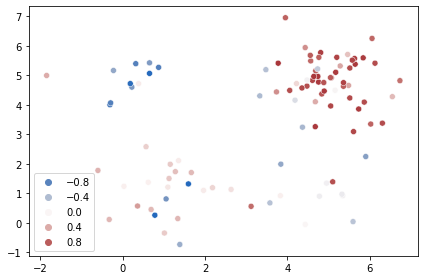

In [339]:
# Model parameters, including the mean
# covariance matrix and the weights for each cluster
init_means = np.array([
    [5, 1],
    [1, 1],
    [0, 5],
    [5, 5],
])

init_covariances = np.array([
    [[.5, 0.], [0, .5]],
    [[.92, .38], [.38, .91]],
    [[.5, 0.], [0, .5]],
    [[.5, 0.], [0, .5]]
])

init_weights = [1 / 8, 1 / 4, 1 / 8, 1 / 2]

# generate data
#np.random.seed(4)
X,y, y_hat = generate_data(100, init_means, init_covariances, init_weights, [0, 1, 0, 1], [0, 0, 1, 1])

sns.scatterplot(
    x=X[:, 0], 
    y=X[:, 1], 
    hue=y - y_hat,
    palette="vlag"
)#torch.nn.functional.binary_cross_entropy(torch.tensor(y_hat), torch.tensor(y), reduction="none").numpy())
plt.tight_layout()


In [340]:
def plot_contours(data, means, covs, errors, title):
    """visualize the gaussian components over the data"""
    plt.figure()
    plt.plot(data[:, 0], data[:, 1], 'ko', alpha=0.3)

    delta = 0.025
    k = means.shape[0]
    x = np.arange(-2.0, 7.0, delta)
    y = np.arange(-2.0, 7.0, delta)
    x_grid, y_grid = np.meshgrid(x, y)
    coordinates = np.array([x_grid.ravel(), y_grid.ravel()]).T
    for i in range(k):
        mean = means[i]
        cov = covs[i]
        z_grid = multivariate_normal(mean, cov).pdf(coordinates).reshape(x_grid.shape)
        plt.contour(
            x_grid, y_grid, z_grid, 10,    
            colors=np.stack(10 * [sns.color_palette("Spectral", as_cmap=True)(errors[i])]))
    
    plt.title(title)
    plt.tight_layout()

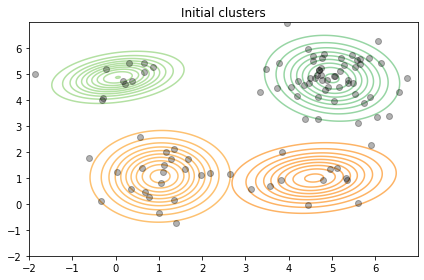

In [341]:
# use our implementation of the EM algorithm 
# and fit a mixture of Gaussians to the simulated data
errors=[False, True, True, False]
gmm = GMM(n_components = 4, n_iters = 100, tol = 1e-4, seed = 4)
gmm.fit(X, y, y_hat)

plot_contours(X, gmm.means, gmm.covs, gmm.errors, 'Initial clusters')

In [338]:
gmm.errors

array([0.30782753, 0.70164575, 0.28810469, 0.81387893])

In [127]:
errors[k]

IndexError: list index out of range

In [300]:
sns.color_palette("mako", as_cmap=True)(0, bytes=True)

(11, 3, 5, 255)